In [1]:
import os
import random
import shutil
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:
# Source and target paths
original_dir = '/kaggle/input/cat-disease/CAT SKIN DISEASE'
base_dir = '/kaggle/working/cat_split'
os.makedirs(base_dir, exist_ok=True)

# Train, val, test folders
for split in ['train', 'valid', 'test']:
    for class_name in os.listdir(original_dir):
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Split files for each class
for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    images = os.listdir(class_path)
    train_imgs, testval_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(testval_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'train', class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'valid', class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'test', class_name, img))


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
valid_data = datasets.ImageFolder(os.path.join(base_dir, 'valid'), transform=transform)
test_data  = datasets.ImageFolder(os.path.join(base_dir, 'test'),  transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False, num_workers=2)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 4),  # 4 classes
    nn.LogSoftmax(dim=1)
)

model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 15


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


In [5]:
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            val_loss += loss.item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    print(f"Train Loss: {running_loss/len(train_loader):.3f} | "
          f"Val Loss: {val_loss/len(valid_loader):.3f} | "
          f"Val Acc: {accuracy/len(valid_loader):.3f}")


Epoch 1/15: 100%|██████████| 22/22 [00:03<00:00,  6.33it/s]


Train Loss: 1.106 | Val Loss: 0.679 | Val Acc: 0.825


Epoch 2/15: 100%|██████████| 22/22 [00:02<00:00,  7.54it/s]


Train Loss: 0.563 | Val Loss: 0.516 | Val Acc: 0.815


Epoch 3/15: 100%|██████████| 22/22 [00:02<00:00,  7.72it/s]


Train Loss: 0.446 | Val Loss: 0.428 | Val Acc: 0.840


Epoch 4/15: 100%|██████████| 22/22 [00:02<00:00,  8.25it/s]


Train Loss: 0.354 | Val Loss: 0.412 | Val Acc: 0.839


Epoch 5/15: 100%|██████████| 22/22 [00:02<00:00,  7.92it/s]


Train Loss: 0.337 | Val Loss: 0.418 | Val Acc: 0.856


Epoch 6/15: 100%|██████████| 22/22 [00:03<00:00,  6.98it/s]


Train Loss: 0.259 | Val Loss: 0.418 | Val Acc: 0.844


Epoch 7/15: 100%|██████████| 22/22 [00:03<00:00,  6.45it/s]


Train Loss: 0.294 | Val Loss: 0.440 | Val Acc: 0.841


Epoch 8/15: 100%|██████████| 22/22 [00:02<00:00,  7.72it/s]


Train Loss: 0.301 | Val Loss: 0.402 | Val Acc: 0.844


Epoch 9/15: 100%|██████████| 22/22 [00:02<00:00,  7.98it/s]


Train Loss: 0.310 | Val Loss: 0.392 | Val Acc: 0.869


Epoch 10/15: 100%|██████████| 22/22 [00:03<00:00,  6.78it/s]


Train Loss: 0.252 | Val Loss: 0.382 | Val Acc: 0.866


Epoch 11/15: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]


Train Loss: 0.180 | Val Loss: 0.318 | Val Acc: 0.894


Epoch 12/15: 100%|██████████| 22/22 [00:02<00:00,  8.03it/s]


Train Loss: 0.183 | Val Loss: 0.333 | Val Acc: 0.900


Epoch 13/15: 100%|██████████| 22/22 [00:02<00:00,  8.06it/s]


Train Loss: 0.239 | Val Loss: 0.349 | Val Acc: 0.856


Epoch 14/15: 100%|██████████| 22/22 [00:02<00:00,  7.93it/s]


Train Loss: 0.162 | Val Loss: 0.321 | Val Acc: 0.900


Epoch 15/15: 100%|██████████| 22/22 [00:02<00:00,  8.03it/s]


Train Loss: 0.162 | Val Loss: 0.332 | Val Acc: 0.894


In [6]:
model.eval()
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_acc += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test Accuracy: {test_acc/len(test_loader):.3f}")


Test Accuracy: 0.871


In [8]:
torch.save(model.state_dict(), "cat_disease_model.h5")

# Move to downloadable path
import shutil
shutil.move("cat_disease_model.h5", "/kaggle/working/cat_disease_model.h5")


'/kaggle/working/cat_disease_model.h5'

Epoch 1/15: 100%|██████████| 22/22 [00:02<00:00,  7.75it/s]


Epoch 1/15 | Train Loss: 0.931 | Train Acc: 0.620 | Val Loss: 0.566 | Val Acc: 0.797


Epoch 2/15: 100%|██████████| 22/22 [00:03<00:00,  7.02it/s]


Epoch 2/15 | Train Loss: 0.484 | Train Acc: 0.827 | Val Loss: 0.526 | Val Acc: 0.791


Epoch 3/15: 100%|██████████| 22/22 [00:02<00:00,  8.16it/s]


Epoch 3/15 | Train Loss: 0.468 | Train Acc: 0.834 | Val Loss: 0.389 | Val Acc: 0.838


Epoch 4/15: 100%|██████████| 22/22 [00:02<00:00,  8.17it/s]


Epoch 4/15 | Train Loss: 0.356 | Train Acc: 0.877 | Val Loss: 0.591 | Val Acc: 0.764


Epoch 5/15: 100%|██████████| 22/22 [00:02<00:00,  7.89it/s]


Epoch 5/15 | Train Loss: 0.379 | Train Acc: 0.856 | Val Loss: 0.342 | Val Acc: 0.885


Epoch 6/15: 100%|██████████| 22/22 [00:02<00:00,  7.74it/s]


Epoch 6/15 | Train Loss: 0.346 | Train Acc: 0.859 | Val Loss: 0.376 | Val Acc: 0.845


Epoch 7/15: 100%|██████████| 22/22 [00:02<00:00,  8.01it/s]


Epoch 7/15 | Train Loss: 0.253 | Train Acc: 0.901 | Val Loss: 0.323 | Val Acc: 0.892


Epoch 8/15: 100%|██████████| 22/22 [00:02<00:00,  8.11it/s]


Epoch 8/15 | Train Loss: 0.238 | Train Acc: 0.911 | Val Loss: 0.357 | Val Acc: 0.865


Epoch 9/15: 100%|██████████| 22/22 [00:02<00:00,  7.80it/s]


Epoch 9/15 | Train Loss: 0.256 | Train Acc: 0.910 | Val Loss: 0.449 | Val Acc: 0.818


Epoch 10/15: 100%|██████████| 22/22 [00:02<00:00,  7.89it/s]


Epoch 10/15 | Train Loss: 0.200 | Train Acc: 0.919 | Val Loss: 0.332 | Val Acc: 0.892


Epoch 11/15: 100%|██████████| 22/22 [00:02<00:00,  7.73it/s]


Epoch 11/15 | Train Loss: 0.159 | Train Acc: 0.954 | Val Loss: 0.343 | Val Acc: 0.872


Epoch 12/15: 100%|██████████| 22/22 [00:02<00:00,  7.59it/s]


Epoch 12/15 | Train Loss: 0.160 | Train Acc: 0.941 | Val Loss: 0.340 | Val Acc: 0.885


Epoch 13/15: 100%|██████████| 22/22 [00:02<00:00,  7.88it/s]


Epoch 13/15 | Train Loss: 0.143 | Train Acc: 0.951 | Val Loss: 0.319 | Val Acc: 0.899


Epoch 14/15: 100%|██████████| 22/22 [00:02<00:00,  7.71it/s]


Epoch 14/15 | Train Loss: 0.142 | Train Acc: 0.951 | Val Loss: 0.330 | Val Acc: 0.899


Epoch 15/15: 100%|██████████| 22/22 [00:02<00:00,  7.57it/s]


Epoch 15/15 | Train Loss: 0.158 | Train Acc: 0.947 | Val Loss: 0.321 | Val Acc: 0.892
Test Accuracy: 0.868


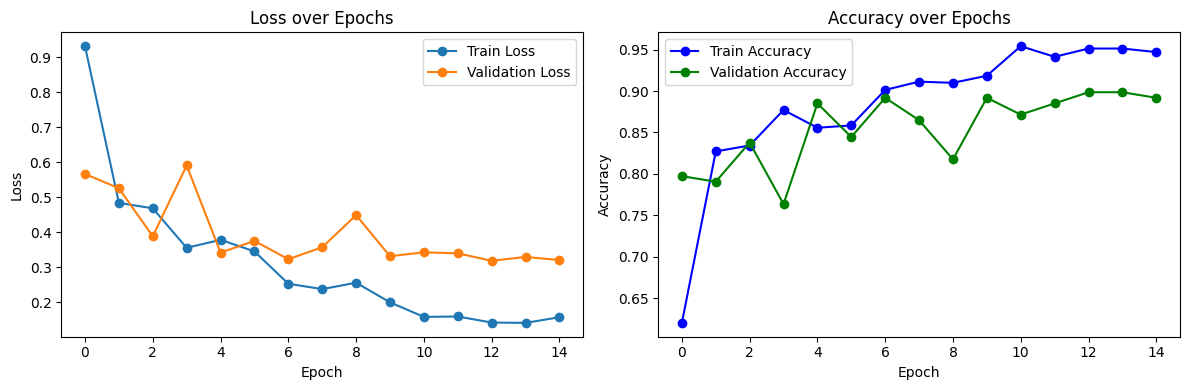

In [3]:
import os
import random
import shutil
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# ======================
# Step 1: Prepare Dataset
# ======================

# Source and target paths
original_dir = '/kaggle/input/cat-disease/CAT SKIN DISEASE'
base_dir = '/kaggle/working/cat_split'
os.makedirs(base_dir, exist_ok=True)

# Create Train, Validation, and Test folders
for split in ['train', 'valid', 'test']:
    for class_name in os.listdir(original_dir):
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Split images
for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    images = os.listdir(class_path)
    train_imgs, testval_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(testval_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'train', class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'valid', class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'test', class_name, img))

# ======================
# Step 2: Load Data
# ======================

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
valid_data = datasets.ImageFolder(os.path.join(base_dir, 'valid'), transform=transform)
test_data  = datasets.ImageFolder(os.path.join(base_dir, 'test'),  transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False, num_workers=2)

# ======================
# Step 3: Build Model
# ======================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 4),  # 4 classes
    nn.LogSoftmax(dim=1)
)

model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 15

# ======================
# Step 4: Train Model
# ======================

# Record loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    running_corrects = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        running_corrects += torch.sum(equals).item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = running_corrects / len(train_loader.dataset)

    model.eval()
    val_loss = 0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            val_loss += loss.item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            val_corrects += torch.sum(equals).item()

    epoch_val_loss = val_loss / len(valid_loader)
    epoch_val_acc = val_corrects / len(valid_loader.dataset)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.3f} | Train Acc: {epoch_train_acc:.3f} | "
          f"Val Loss: {epoch_val_loss:.3f} | Val Acc: {epoch_val_acc:.3f}")

# ======================
# Step 5: Evaluate Model
# ======================

model.eval()
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_acc += torch.sum(equals).item()

test_acc = test_acc / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.3f}")

# ======================
# Step 6: Save Model
# ======================

torch.save(model.state_dict(), "cat_disease_model.h5")

# Move to working path if needed
import shutil
shutil.move("cat_disease_model.h5", "/kaggle/working/cat_disease_model.h5")

# ======================
# Step 7: Plot Training History
# ======================

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
